In [0]:
# To determine which version you're using:
!pip show tensorflow

# For the latest nightly build:
# !pip install tf-nightly
# For the current version: 
#!pip install --upgrade tensorflow

# For a specific version:
#!pip install tensorflow==1.2


Name: tensorflow
Version: 2.2.0rc3
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, google-pasta, astunparse, keras-preprocessing, wheel, protobuf, scipy, gast, opt-einsum, termcolor, tensorflow-estimator, numpy, grpcio, wrapt, tensorboard, absl-py, h5py
Required-by: fancyimpute


# Import


In [0]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
import math

import numpy as np
from PIL import Image
import os
import cv2

from skimage.util import random_noise

In [0]:
# Variablen

IMG_Height = 128
IMG_Width = 64

# 1) Erzeuger

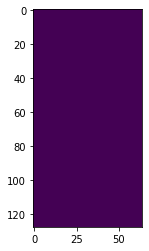

In [0]:
# Bild Erzeuger
def createImage():
  ArrayZiel = []

  for x in range(0, IMG_Height):
    tempArray = []
    for y in range(0, IMG_Width):
      tempArray.append(0)
    ArrayZiel.append(np.array(tempArray))
  return np.array(ArrayZiel)


image = createImage()

plt.imshow(image)
plt.show()

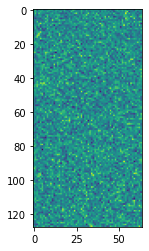

In [0]:
# Add Noise
def add_gaussian_noise(img):
    mean = 0
    var = 10
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, (IMG_Height, IMG_Width))

    noisy_image = np.zeros(img.shape, np.float32)

    if len(img.shape) == 2:
        noisy_image = img + gaussian
    else:
        noisy_image[:, :, 0] = img[:, :, 0] + gaussian
        noisy_image[:, :, 1] = img[:, :, 1] + gaussian
        noisy_image[:, :, 2] = img[:, :, 2] + gaussian

    cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

  
image = add_gaussian_noise(image)


plt.imshow(image)
plt.show()

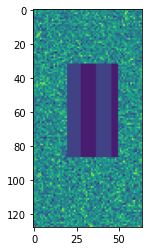

In [0]:
# add Table

def addTabel(image):
  x1 = int(random.randint(0, IMG_Height-30))
  x2 = int(random.randint(x1+20, IMG_Height-2))

  y1 = int(random.randint(0, IMG_Width-30))
  y2 = int(random.randint(y1+10, IMG_Width-2))

  width = x2-x1
  height = y2-y1

  AnzahlTabellen = random.randint(2,5)

  # Berechne Tabelle:
  b = int(width / AnzahlTabellen)

  for x in range(x1,x2):
    for y in range(y1, y2):
      Temp = math.sin((y / b) * 2 * math.pi)
      if(Temp > 0):
        image[x][y] = 50
      else:
        image[x][y] = 20

  return image, x1, y1, x2, y2

image, x1,y1,x2,y2 = addTabel(image)

plt.imshow(image)
plt.show()

In [0]:
TrainDataset = []
TrainLabelSet = []

TestDataSet = []
TestLabelSet = []

AnzahlAnTrainDaten = 50000
AnzahlAnTestDaten = 1000
DropoutRate = 0.5

In [0]:
def CreateLabelData(x1, y1, x2, y2):
  Array = []

  Array1 = []
  Array1.append(x1)
  Array1.append(y1)
  Array1 = np.asarray(Array1)
  Array.append(Array1)

  Array1 = []
  Array1.append(x2)
  Array1.append(y2)
  Array1 = np.asarray(Array1)
  Array.append(Array1)

  Array = np.asarray(Array)
  return Array

In [0]:
# Erstellen der Train Daten
for i in range(0, AnzahlAnTrainDaten):
  image = createImage()
  image = add_gaussian_noise(image)
  image, x1, y1, x2, y2 = addTabel(image)
  labelArray = CreateLabelData(x1, y1, x2, y2)
  TrainDataset.append(np.asarray(image))
  TrainLabelSet.append(np.asarray(labelArray))

In [0]:
# Erstellen der TestDaten
for i in range(0, AnzahlAnTestDaten):
  image = createImage()
  image = add_gaussian_noise(image)
  image, x1, y1, x2, y2 = addTabel(image)
  labelArray = CreateLabelData(x1, y1, x2, y2)
  TestDataSet.append(np.asarray(image))
  TestLabelSet.append(np.asarray(labelArray))

In [0]:
TrainDataset = np.asarray(TrainDataset, dtype=np.float32)
TrainLabelSet = np.asarray(TrainLabelSet, dtype=np.float32)
print(TrainDataset.shape)

TestDataSet = np.asarray(TestDataSet, dtype=np.float32)
TestLabelSet = np.asarray(TestLabelSet, dtype=np.float32)
print(TestDataSet.shape)

(50000, 128, 64)
(1000, 128, 64)


In [0]:
input = keras.layers.Input((IMG_Height, IMG_Width, 1))

b1 = keras.layers.MaxPooling2D()(input)
b1 = keras.layers.Conv2D(1, 1, padding='same', activation='relu')(b1)
b1 = keras.layers.MaxPooling2D()(b1)
drop1 = keras.layers.Dropout(DropoutRate)(b1)

b2 = keras.layers.Conv2D(1, 3, padding='same', activation='relu')(drop1)
b2 = keras.layers.MaxPooling2D()(b2)
drop2 = keras.layers.Dropout(DropoutRate)(b2)

b3 = keras.layers.Conv2D(1, 3, padding='same', activation='relu')(drop2)
b3 = keras.layers.MaxPooling2D()(b3)

Flatten = keras.layers.Flatten()(b3)
d1 = keras.layers.Dense(500, activation='swish')(Flatten)
d2 = keras.layers.Dense(300, activation='relu')(d1)
d2 = keras.layers.Dropout(DropoutRate)(d2)
d2 = keras.layers.Dense(200, activation='relu')(d2)
d2 = keras.layers.Dense(4, activation='linear')(d2)

Output = keras.layers.Reshape((2, 2))(d2)


model = keras.models.Model(input, Output)

In [0]:
model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])



In [0]:
print(TrainLabelSet[0])

[[ 8. 22.]
 [99. 52.]]


In [0]:
model.fit(x = TrainDataset, y = TrainLabelSet, shuffle=True, epochs=20, validation_split=0.3)     

Epoch 1/20
1094/1094 [==============================] - 34s 31ms/step - loss: -34.1193 - accuracy: 0.2948 - val_loss: 399.5188 - val_accuracy: 0.4251
Epoch 2/20
1094/1094 [==============================] - 34s 31ms/step - loss: -34.6334 - accuracy: 0.2910 - val_loss: 399.5188 - val_accuracy: 0.4251
Epoch 3/20
1094/1094 [==============================] - 34s 31ms/step - loss: -34.6686 - accuracy: 0.2903 - val_loss: 399.5188 - val_accuracy: 0.4251
Epoch 4/20
1094/1094 [==============================] - 34s 31ms/step - loss: -721.3552 - accuracy: 0.8363 - val_loss: -19.4742 - val_accuracy: 0.8942
Epoch 5/20
1094/1094 [==============================] - 34s 31ms/step - loss: -778.1378 - accuracy: 0.4375 - val_loss: -218.7373 - val_accuracy: 0.1058
Epoch 6/20
1094/1094 [==============================] - 34s 31ms/step - loss: -778.1697 - accuracy: 0.1076 - val_loss: -218.7373 - val_accuracy: 0.1058
Epoch 7/20
1094/1094 [==============================] - 34s 31ms/step - loss: -778.1694 - accur

In [0]:
loss, acc = model.evaluate(TestDataSet, TestLabelSet, verbose=2)

print(acc)

32/32 - 0s - loss: -2.1387e+02 - accuracy: 0.1005
0.10050000250339508


In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 64, 1)]      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 32, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 32, 1)         2         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 16, 1)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 16, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 16, 1)         10        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 8, 1)          0   

(1, 128, 64)
(1, 2, 2)
3


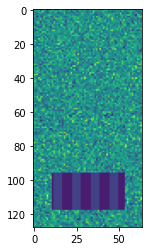

[[ 96  11]
 [118  54]]
[[0.4470147  0.80701864]
 [0.59898823 1.0110631 ]]


In [0]:
newImage = createImage()
newImage = add_gaussian_noise(newImage)
newImage, x1, y1, x2, y2 = addTabel(newImage)
labelArray = CreateLabelData(x1, y1, x2, y2)

Array = []
Array.append(newImage)

newImage = np.asarray(Array, dtype=np.float32)
print(newImage.shape)

prediction = model.predict(newImage)
prediction = np.asarray(prediction, dtype=np.float32)

print(prediction.shape)
print(np.argmax(prediction[0]))

plt.imshow(newImage[0])
plt.show()

print(labelArray)
print(prediction[0])


# Mehrfaches Training
- Hat das einen Einfluss???


In [0]:
AnzahlvonZusätzen = 1

for i in range(0, AnzahlvonZusätzen):
  # Alte Daten Weg
  TrainDataset = []
  TrainLabelSet = []
  TestDataSet = []
  TestLabelSet = []

  # neue Daten her
  for i in range(0, AnzahlAnTrainDaten):
    image = createImage()
    image = add_gaussian_noise(image)
    image, x1, y1, x2, y2 = addTabel(image)
    labelArray = CreateLabelData(x1, y1, x2, y2)
    TrainDataset.append(np.asarray(image))
    TrainLabelSet.append(np.asarray(labelArray))
  
  # Und neue Test Daten
  for i in range(0, AnzahlAnTestDaten):
    image = createImage()
    image = add_gaussian_noise(image)
    image, x1, y1, x2, y2 = addTabel(image)
    labelArray = CreateLabelData(x1, y1, x2, y2)
    TestDataSet.append(np.asarray(image))
    TestLabelSet.append(np.asarray(labelArray))

  TrainDataset = np.asarray(TrainDataset, dtype=np.float32)
  TrainLabelSet = np.asarray(TrainLabelSet, dtype=np.float32)
  TestDataSet = np.asarray(TestDataSet, dtype=np.float32)
  TestLabelSet = np.asarray(TestLabelSet, dtype=np.float32)

  # Train Model and Print Acc
  model.fit(x = TrainDataset, y = TrainLabelSet, shuffle=True, epochs=10, validation_split=0.3)
  loss, acc = model.evaluate(TestDataSet, TestLabelSet, verbose=2)
  print(acc)

Epoch 1/10
1094/1094 [==============================] - 37s 33ms/step - loss: -776.9865 - accuracy: 0.1090 - val_loss: -219.7294 - val_accuracy: 0.1063
Epoch 2/10
1094/1094 [==============================] - 37s 33ms/step - loss: -776.9877 - accuracy: 0.1093 - val_loss: -219.7294 - val_accuracy: 0.1063
Epoch 3/10
1094/1094 [==============================] - 37s 34ms/step - loss: -776.9870 - accuracy: 0.1092 - val_loss: -219.7294 - val_accuracy: 0.1063
Epoch 4/10
1094/1094 [==============================] - 37s 34ms/step - loss: -776.9871 - accuracy: 0.1092 - val_loss: -219.7294 - val_accuracy: 0.1063
Epoch 5/10
1094/1094 [==============================] - 37s 34ms/step - loss: -776.9876 - accuracy: 0.1092 - val_loss: -219.7294 - val_accuracy: 0.1063
Epoch 6/10
1094/1094 [==============================] - 37s 34ms/step - loss: -776.9869 - accuracy: 0.1091 - val_loss: -219.7294 - val_accuracy: 0.1063
Epoch 7/10
1094/1094 [==============================] - 37s 34ms/step - loss: -776.9862 

(1, 128, 64)
(1, 2, 2)
3


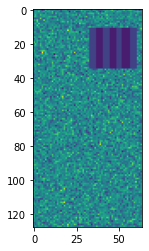

[[11 33]
 [35 61]]
[[0.4470147  0.80701864]
 [0.59898823 1.0110631 ]]


In [0]:
newImage = createImage()
newImage = add_gaussian_noise(newImage)
newImage, x1, y1, x2, y2 = addTabel(newImage)
labelArray = CreateLabelData(x1, y1, x2, y2)

Array = []
Array.append(newImage)

newImage = np.asarray(Array, dtype=np.float32)
print(newImage.shape)

prediction = model.predict(newImage)
prediction = np.asarray(prediction, dtype=np.float32)

print(prediction.shape)
print(np.argmax(prediction[0]))

plt.imshow(newImage[0])
plt.show()

print(labelArray)
print(prediction[0])


In [0]:
%tensorboard --logdir {logdir}/sizes

UsageError: Line magic function `%tensorboard` not found.


In [0]:
model.save('TESTMODELLFUNKTIONIERBITTE')